# Comparison of embedders for retrieving legal articles (Balanced sampling)

## Import required libraries

In [46]:
import pandas as pd
import numpy as np
import sys
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer
import torch
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)  

if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")


Using CPU


## Loading and exploring the dataset

In [47]:
PROJECT_ROOT = "/Users/theother_archee/CursorProjects/SmartClause/" # Use your path to SmartClause repository

if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

chunks_path = PROJECT_ROOT + "experiments/dataset_codes_rf_chunking_800chunksize_500overlap.csv"
rules_path = PROJECT_ROOT + "parser/dataset/dataset_codes_rf.csv"

chunks_df = pd.read_csv(chunks_path)
rules_df = pd.read_csv(rules_path)

df = pd.merge(chunks_df, rules_df, on='rule_id', how='left', suffixes=('_chunk', '_rule'))

print(f"Shape: {df.shape}")

Shape: (48517, 15)


In [48]:
df['file'].unique()

array(['Арбитражный процессуальный кодекс Российской Федерации.doc',
       'Бюджетный кодекс Российской Федерации.doc',
       'Водный кодекс Российской Федерации.doc',
       'Воздушный кодекс Российской Федерации.doc',
       'Градостроительный кодекс Российской Федерации.doc',
       'Гражданский кодекс Российской Федерации. Часть вторая.doc',
       'Гражданский кодекс Российской Федерации. Часть первая.doc',
       'Гражданский кодекс Российской Федерации. Часть третья.doc',
       'Гражданский кодекс Российской Федерации. Часть четвертая.doc',
       'Гражданский процессуальный кодекс Российской Федерации.doc',
       'Жилищный кодекс Российской Федерации.doc',
       'Земельный кодекс Российской Федерации.doc',
       'Кодекс административного судопроизводства Российской Федерации.doc',
       'Кодекс внутреннего водного транспорта Российской Федерации.doc',
       'Кодекс торгового мореплавания Российской Федерации.doc',
       'Лесной кодекс Российской Федерации.doc',
       

## Select 10 random records from each unique file, so we will create correctly distributed validation sample

In [49]:
unique_files = df['file'].unique()

samples_per_file = 10
sample_dfs = []

for file_name in unique_files:
    file_df = df[df['file'] == file_name]
    
    # If the file has less than 10 records, we take all of them
    n_samples = min(samples_per_file, len(file_df))
    file_sample = file_df.sample(n=n_samples, random_state=42).reset_index(drop=True)
    sample_dfs.append(file_sample)

# Combine all samples
sample_df = pd.concat(sample_dfs, ignore_index=True)

print(f"\n📊 Final sample size: {sample_df.shape}")
print(f"📈 Distribution by files:")
print(sample_df['file'].value_counts().sort_index())



📊 Final sample size: (220, 15)
📈 Distribution by files:
file
Арбитражный процессуальный кодекс Российской Федерации.doc            10
Бюджетный кодекс Российской Федерации.doc                             10
Водный кодекс Российской Федерации.doc                                10
Воздушный кодекс Российской Федерации.doc                             10
Градостроительный кодекс Российской Федерации.doc                     10
Гражданский кодекс Российской Федерации. Часть вторая.doc             10
Гражданский кодекс Российской Федерации. Часть первая.doc             10
Гражданский кодекс Российской Федерации. Часть третья.doc             10
Гражданский кодекс Российской Федерации. Часть четвертая.doc          10
Гражданский процессуальный кодекс Российской Федерации.doc            10
Жилищный кодекс Российской Федерации.doc                              10
Земельный кодекс Российской Федерации.doc                             10
Кодекс административного судопроизводства Российской Федерации

## Embedding quality metrics functions (copy from routes.py)

In [50]:
def compute_retrieval_metrics(embeddings, labels):
    """
    Calculates embedding quality metrics:
        - Total dimension variance
        - Silhouette Score (cosine distance, grouped by file_name)
        - Effective Intrinsic Dimensionality (EID) and Dimensionality Redundancy (DR)
    """

    if embeddings is None or len(embeddings) < 2:
        return {
            'total_variance': 0.0,
            'silhouette_score': 0.0,
            'eid': 0.0,
            'dr': 0.0
        }
    
    embeddings = np.array(embeddings)
    labels = np.array(labels)

    # 1. Total dimension variance
    dim_variances = np.var(embeddings, axis=0)
    total_variance = float(np.sum(dim_variances))

    # 2. Silhouette Score (cosine distance, группировка по file_name)
    try:
        # Преобразуем метки в числовые индексы
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        numeric_labels = le.fit_transform(labels)
        
        # Check that we have at least 2 classes
        if len(set(numeric_labels)) >= 2:
            sil_score = float(silhouette_score(embeddings, numeric_labels, metric='cosine'))
        else:
            print("⚠️ Not enough classes to calculate Silhouette Score")
            sil_score = 0.0
    except Exception as e:
        print(f"⚠️ Error calculating Silhouette Score: {e}")
        sil_score = 0.0

    # 3. EID & DR (alpha=0.95)
    try:
        variances = np.var(embeddings, axis=0)
        sorted_vars = np.sort(variances)[::-1]
        total_var = np.sum(sorted_vars)
        
        if total_var > 0 and len(sorted_vars) > 0:
            cumsum = np.cumsum(sorted_vars) / total_var
            alpha = 0.95
            alpha_indices = np.where(cumsum >= alpha)[0]
            
            if len(alpha_indices) > 0:
                j_alpha = alpha_indices[0]
                S_j = cumsum[j_alpha-1] if j_alpha > 0 else 0
                if j_alpha < len(sorted_vars) and sorted_vars[j_alpha] > 0:
                    eid = j_alpha + (alpha - S_j) / sorted_vars[j_alpha]
                else:
                    eid = float(j_alpha)
            else:
                eid = float(len(sorted_vars))
            
            dr = 1.0 - eid / len(sorted_vars)
        else:
            eid = 0.0
            dr = 0.0
    except Exception as e:
        print(f"⚠️ Error calculating EID/DR: {e}")
        eid = 0.0
        dr = 0.0

    return {
        'total_variance': total_variance,
        'silhouette_score': sil_score,
        'eid': float(eid),
        'dr': float(dr)
    }


## List of SOTA embedders for comparison

In [ ]:
embedder_models = {
    # === Fast models (optimized for speed) ===
    'sentence-transformers/all-MiniLM-L6-v2': {
        'name': 'MiniLM-L6-v2',
        'description': 'Fast and efficient model (22M params)',
        'max_length': 512
    },
    'sentence-transformers/all-MiniLM-L12-v2': {
        'name': 'MiniLM-L12-v2',
        'description': 'Larger MiniLM version (33M params)',
        'max_length': 512
    },
    'sentence-transformers/msmarco-MiniLM-L-6-v3': {
        'name': 'MS-MARCO-MiniLM',
        'description': 'Fast search-optimized model (22M params)',
        'max_length': 512
    },
    
    # === High quality models (best accuracy) ===
    'sentence-transformers/all-mpnet-base-v2': {
        'name': 'MPNet-base-v2',
        'description': 'High quality performances (109M params)',
        'max_length': 512
    },
    'sentence-transformers/all-roberta-large-v1': {
        'name': 'RoBERTa-large-v1',
        'description': 'Large RoBERTa model (355M params)',
        'max_length': 512
    },
    'sentence-transformers/msmarco-distilbert-base-v4': {
        'name': 'MS-MARCO-DistilBERT',
        'description': 'Optimized for search/retrieval (66M params)',
        'max_length': 512
    },
    
    # === Multilingual Models ===
    'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2': {
        'name': 'Multilingual-MiniLM-L12',
        'description': 'Multilingual paraphrase model (118M params)',
        'max_length': 512
    },
    'sentence-transformers/paraphrase-multilingual-mpnet-base-v2': {
        'name': 'Multilingual-MPNet',
        'description': 'Multilingual MPNet version (278M params)',
        'max_length': 512
    },
    'sentence-transformers/distiluse-base-multilingual-cased': {
        'name': 'DistilUSE-Multilingual',
        'description': 'Multilingual Universal Sentence Encoder (135M params)',
        'max_length': 512
    },
    
    # === New BGE models (high quality) ===
    'BAAI/bge-small-en-v1.5': {
        'name': 'BGE-small-en-v1.5',
        'description': 'BGE small English model (33M params)',
        'max_length': 512
    },
    'BAAI/bge-base-en-v1.5': {
        'name': 'BGE-base-en-v1.5',
        'description': 'BGE base English model (109M params)',
        'max_length': 512
    },
    'BAAI/bge-m3': {
        'name': 'BGE-M3',
        'description': 'Multilingual BGE model (560M params)',
        'max_length': 8192
    },
    
    # === E5 models from Microsoft ===
    'intfloat/e5-small-v2': {
        'name': 'E5-small-v2',
        'description': 'Microsoft E5 small model (33M params)',
        'max_length': 512
    },
    'intfloat/e5-base-v2': {
        'name': 'E5-base-v2',
        'description': 'Microsoft E5 base model (109M params)',
        'max_length': 512
    }
}


## Generation of embeddings

In [52]:
def generate_embeddings_for_model(model_id, texts, labels):
    """
    Generates embeddings for a given model.
    """

    print(f"Loading model: {model_id}")
    
    try:
        # Loading the model
        model = SentenceTransformer(model_id)
        
        embeddings = model.encode(
            texts, 
            batch_size=32,
            show_progress_bar=True,
            convert_to_numpy=True
        )
        
        print(f"Embeddings are ready! Dimension: {embeddings.shape}")
        
        # Calculate metrics
        metrics = compute_retrieval_metrics(embeddings, labels)
        
        return {
            'embeddings': embeddings,
            'metrics': metrics,
            'model_id': model_id,
            'embedding_dim': embeddings.shape[1] if len(embeddings) > 0 else 0
        }
        
    except Exception as e:
        print(f"❌ Error processing model {model_id}: {e}")
        return None


In [63]:
texts = sample_df['chunk_text'].astype(str).tolist()
labels = sample_df['file'].astype(str).tolist()

results = {}
total_start_time = time.time()

for i, (model_id, model_info) in enumerate(embedder_models.items(), 1):
    print(f"\n[{i}/{len(embedder_models)}] Processing model: {model_info['name']}")
    start_time = time.time()
    
    # Generate embeddings
    result = generate_embeddings_for_model(
        model_id=model_id,
        texts=texts,
        labels=labels
    )
    
    if result is not None:
        end_time = time.time()
        processing_time = end_time - start_time
        
        result['processing_time'] = processing_time
        result['model_info'] = model_info
        results[model_id] = result
        
        print(f"Processing time: {processing_time:.2f} sec")
        print(f"Metrics:")
        for metric_name, value in result['metrics'].items():
            print(f"   - {metric_name}: {value:.4f}")
    else:
        print(f"Model {model_id} skipped due to error")
    
    print("-" * 40)

total_time = time.time() - total_start_time
print(f"\nAll models processed in {total_time:.2f} sec")
print(f"Successfully processed: {len(results)}/{len(embedder_models)} models")



[1/15] Processing model: MiniLM-L6-v2
Loading model: sentence-transformers/all-MiniLM-L6-v2


Batches: 100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


Embeddings are ready! Dimension: (220, 384)
Processing time: 12.50 sec
Metrics:
   - total_variance: 0.2232
   - silhouette_score: -0.0958
   - eid: 352.6829
   - dr: 0.0816
----------------------------------------

[2/15] Processing model: MiniLM-L12-v2
Loading model: sentence-transformers/all-MiniLM-L12-v2


Batches: 100%|██████████| 7/7 [00:02<00:00,  3.20it/s]


Embeddings are ready! Dimension: (220, 384)
Processing time: 80.57 sec
Metrics:
   - total_variance: 0.4453
   - silhouette_score: -0.0950
   - eid: 352.6355
   - dr: 0.0817
----------------------------------------

[3/15] Processing model: MS-MARCO-MiniLM
Loading model: sentence-transformers/msmarco-MiniLM-L-6-v3


Batches: 100%|██████████| 7/7 [00:16<00:00,  2.41s/it]


Embeddings are ready! Dimension: (220, 384)
Processing time: 61.03 sec
Metrics:
   - total_variance: 9.9858
   - silhouette_score: -0.1959
   - eid: 344.0825
   - dr: 0.1040
----------------------------------------

[4/15] Processing model: MPNet-base-v2
Loading model: sentence-transformers/all-mpnet-base-v2


Batches: 100%|██████████| 7/7 [00:21<00:00,  3.10s/it]


Embeddings are ready! Dimension: (220, 768)
Processing time: 26.87 sec
Metrics:
   - total_variance: 0.2721
   - silhouette_score: -0.1061
   - eid: 672.7357
   - dr: 0.1240
----------------------------------------

[5/15] Processing model: RoBERTa-large-v1
Loading model: sentence-transformers/all-roberta-large-v1


Batches: 100%|██████████| 7/7 [00:14<00:00,  2.09s/it]


Embeddings are ready! Dimension: (220, 1024)
Processing time: 153.79 sec
Metrics:
   - total_variance: 0.3110
   - silhouette_score: -0.0876
   - eid: 938.7845
   - dr: 0.0832
----------------------------------------

[6/15] Processing model: MS-MARCO-DistilBERT
Loading model: sentence-transformers/msmarco-distilbert-base-v4


Batches: 100%|██████████| 7/7 [00:04<00:00,  1.40it/s]


Embeddings are ready! Dimension: (220, 768)
Processing time: 95.08 sec
Metrics:
   - total_variance: 7.9104
   - silhouette_score: -0.1787
   - eid: 699.0056
   - dr: 0.0898
----------------------------------------

[7/15] Processing model: Multilingual-MiniLM-L12
Loading model: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2


Batches: 100%|██████████| 7/7 [00:00<00:00,  9.16it/s]


Embeddings are ready! Dimension: (220, 384)
Processing time: 6.44 sec
Metrics:
   - total_variance: 5.0788
   - silhouette_score: 0.0268
   - eid: 348.1689
   - dr: 0.0933
----------------------------------------

[8/15] Processing model: Multilingual-MPNet
Loading model: sentence-transformers/paraphrase-multilingual-mpnet-base-v2


Batches: 100%|██████████| 7/7 [00:06<00:00,  1.10it/s]


Embeddings are ready! Dimension: (220, 768)
Processing time: 159.35 sec
Metrics:
   - total_variance: 2.9491
   - silhouette_score: 0.0319
   - eid: 659.1159
   - dr: 0.1418
----------------------------------------

[9/15] Processing model: DistilUSE-Multilingual
Loading model: sentence-transformers/distiluse-base-multilingual-cased


Batches: 100%|██████████| 7/7 [00:09<00:00,  1.36s/it]


Embeddings are ready! Dimension: (220, 512)
Processing time: 128.30 sec
Metrics:
   - total_variance: 0.5442
   - silhouette_score: 0.0187
   - eid: 466.6912
   - dr: 0.0885
----------------------------------------

[10/15] Processing model: BGE-small-en-v1.5
Loading model: BAAI/bge-small-en-v1.5


Batches: 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


Embeddings are ready! Dimension: (220, 384)
Processing time: 94.30 sec
Metrics:
   - total_variance: 0.1712
   - silhouette_score: -0.0828
   - eid: 359.7783
   - dr: 0.0631
----------------------------------------

[11/15] Processing model: BGE-base-en-v1.5
Loading model: BAAI/bge-base-en-v1.5


Batches: 100%|██████████| 7/7 [00:15<00:00,  2.27s/it]


Embeddings are ready! Dimension: (220, 768)
Processing time: 376.80 sec
Metrics:
   - total_variance: 0.1814
   - silhouette_score: -0.0644
   - eid: 709.2895
   - dr: 0.0764
----------------------------------------

[12/15] Processing model: BGE-M3
Loading model: BAAI/bge-m3


Batches: 100%|██████████| 7/7 [00:18<00:00,  2.68s/it]


Embeddings are ready! Dimension: (220, 1024)
Processing time: 39.92 sec
Metrics:
   - total_variance: 0.4897
   - silhouette_score: 0.0547
   - eid: 920.1692
   - dr: 0.1014
----------------------------------------

[13/15] Processing model: E5-small-v2
Loading model: intfloat/e5-small-v2


Batches: 100%|██████████| 7/7 [00:15<00:00,  2.18s/it]


Embeddings are ready! Dimension: (220, 384)
Processing time: 114.93 sec
Metrics:
   - total_variance: 0.0702
   - silhouette_score: -0.0729
   - eid: 363.5735
   - dr: 0.0532
----------------------------------------

[14/15] Processing model: E5-base-v2
Loading model: intfloat/e5-base-v2


Batches: 100%|██████████| 7/7 [00:14<00:00,  2.04s/it]


Embeddings are ready! Dimension: (220, 768)
Processing time: 19.82 sec
Metrics:
   - total_variance: 0.0987
   - silhouette_score: -0.0292
   - eid: 717.2712
   - dr: 0.0661
----------------------------------------

[15/15] Processing model: Multilingual-E5-small
Loading model: intfloat/multilingual-e5-small


KeyboardInterrupt: 

## Create a DataFrame with the results

In [64]:
comparison_data = []

for model_id, result in results.items():
    row = {
        'Model': result['model_info']['name'],
        'Model_ID': model_id,
        'Description': result['model_info']['description'],
        'Embedding_Dim': result['embedding_dim'],
        'Processing_Time': result['processing_time'],
        'Total_Variance': result['metrics']['total_variance'],
        'Silhouette_Score': result['metrics']['silhouette_score'],
        'EID': result['metrics']['eid'],
        'DR': result['metrics']['dr']
    }
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)

# Sort by Silhouette Score (better = higher)
comparison_df = comparison_df.sort_values('Silhouette_Score', ascending=False)

print("📊 SUMMARY TABLE OF RESULTS")
print("=" * 80)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

print(comparison_df[['Model', 'Embedding_Dim', 'Processing_Time', 
                    'Total_Variance', 'Silhouette_Score', 'EID', 'DR']].to_string(index=False))

print("\n" + "=" * 80)

# Showing the top 3 models by Silhouette Score
print("TOP 3 MODELS BY SILHOUETTE SCORE:")
for i, (_, row) in enumerate(comparison_df.head(3).iterrows(), 1):
    print(f"{i}. {row['Model']} - Silhouette: {row['Silhouette_Score']:.4f}")

# Show the fastest model
fastest_model = comparison_df.loc[comparison_df['Processing_Time'].idxmin()]
print(f"\nFASTEST MODEL: {fastest_model['Model']} ({fastest_model['Processing_Time']:.2f} sec)")

# Show the model with the best EID
best_eid_model = comparison_df.loc[comparison_df['EID'].idxmax()]
print(f"BEST EID: {best_eid_model['Model']} ({best_eid_model['EID']:.4f})")


📊 SUMMARY TABLE OF RESULTS
                  Model  Embedding_Dim  Processing_Time  Total_Variance  Silhouette_Score      EID     DR
                 BGE-M3           1024          39.9196          0.4897            0.0547 920.1692 0.1014
     Multilingual-MPNet            768         159.3495          2.9491            0.0319 659.1159 0.1418
Multilingual-MiniLM-L12            384           6.4358          5.0788            0.0268 348.1689 0.0933
 DistilUSE-Multilingual            512         128.3011          0.5442            0.0187 466.6912 0.0885
             E5-base-v2            768          19.8244          0.0987           -0.0292 717.2712 0.0661
       BGE-base-en-v1.5            768         376.7992          0.1814           -0.0644 709.2895 0.0764
            E5-small-v2            384         114.9347          0.0702           -0.0729 363.5735 0.0532
      BGE-small-en-v1.5            384          94.2999          0.1712           -0.0828 359.7783 0.0631
       RoBERTa-larg

## Visualization of comparison results

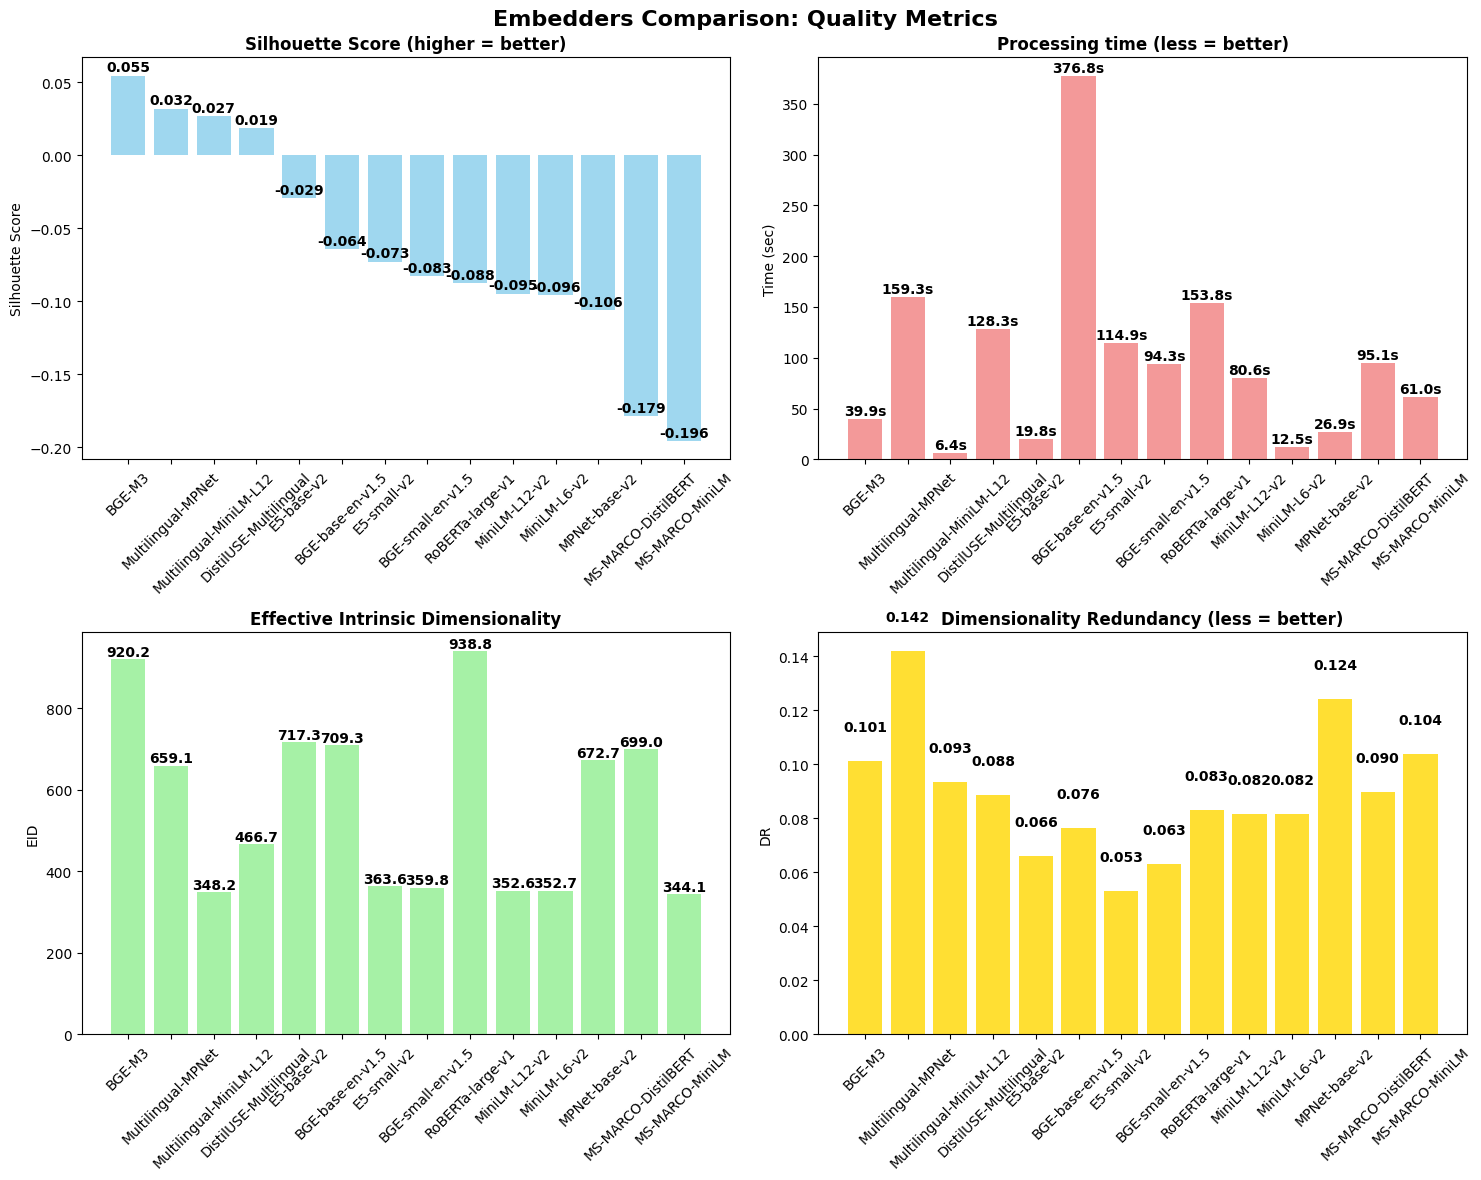

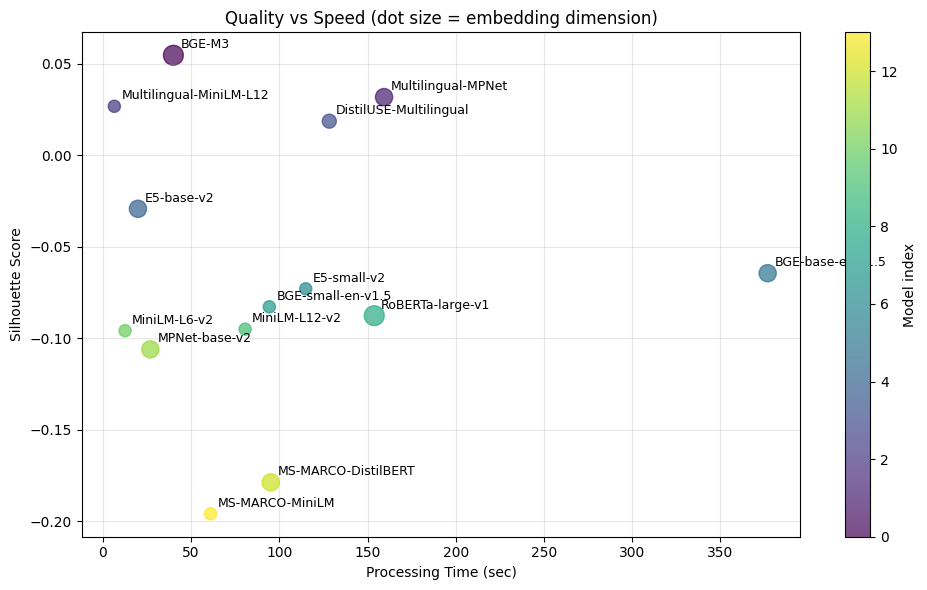

In [65]:
# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Embedders Comparison: Quality Metrics', fontsize=16, fontweight='bold')

# 1. Silhouette Score
ax1 = axes[0, 0]
bars1 = ax1.bar(comparison_df['Model'], comparison_df['Silhouette_Score'], 
                color='skyblue', alpha=0.8)
ax1.set_title('Silhouette Score (higher = better)', fontweight='bold')
ax1.set_ylabel('Silhouette Score')
ax1.tick_params(axis='x', rotation=45)

for bar, value in zip(bars1, comparison_df['Silhouette_Score']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

#2. Processing time
ax2 = axes[0, 1]
bars2 = ax2.bar(comparison_df['Model'], comparison_df['Processing_Time'], 
                color='lightcoral', alpha=0.8)
ax2.set_title('Processing time (less = better)', fontweight='bold')
ax2.set_ylabel('Time (sec)')
ax2.tick_params(axis='x', rotation=45)

for bar, value in zip(bars2, comparison_df['Processing_Time']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{value:.1f}s', ha='center', va='bottom', fontweight='bold')

# 3. EID (Effective Intrinsic Dimensionality)
ax3 = axes[1, 0]
bars3 = ax3.bar(comparison_df['Model'], comparison_df['EID'], 
                color='lightgreen', alpha=0.8)
ax3.set_title('Effective Intrinsic Dimensionality', fontweight='bold')
ax3.set_ylabel('EID')
ax3.tick_params(axis='x', rotation=45)

for bar, value in zip(bars3, comparison_df['EID']):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{value:.1f}', ha='center', va='bottom', fontweight='bold')

# 4. Dimensionality Redundancy
ax4 = axes[1, 1]
bars4 = ax4.bar(comparison_df['Model'], comparison_df['DR'], 
                color='gold', alpha=0.8)
ax4.set_title('Dimensionality Redundancy (less = better)', fontweight='bold')
ax4.set_ylabel('DR')
ax4.tick_params(axis='x', rotation=45)

for bar, value in zip(bars4, comparison_df['DR']):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Additional visualization: Scatter plot quality vs speed
plt.figure(figsize=(10, 6))
scatter = plt.scatter(comparison_df['Processing_Time'], comparison_df['Silhouette_Score'], 
                        s=comparison_df['Embedding_Dim']/5, alpha=0.7, c=range(len(comparison_df)), 
                        cmap='viridis')

# Adding annotations
for i, row in comparison_df.iterrows():
    plt.annotate(row['Model'], 
                (row['Processing_Time'], row['Silhouette_Score']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.xlabel('Processing Time (sec)')
plt.ylabel('Silhouette Score')
plt.title('Quality vs Speed ​​(dot size = embedding dimension)')
plt.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Model index')

plt.tight_layout()
plt.show()


## CONCLUSION AND PRACTICAL RECOMMENDATIONS

MAIN WINNERS:

1. **BGE-M3** - ABSOLUTE LEADER IN QUALITY
- **Silhouette Score**: 0.0547 (the best!)
- **Speed**: 40 sec (acceptable)
- **Dimensionality**: 1024D (rich representation)
- **Conclusion**: The best model for production, where quality is important

2. Multilingual-MiniLM-L12** - BEST BALANCE
- **Silhouette Score**: 0.0268 (3rd place in quality)
- **Speed**: 6.4 sec (THE BEST FAST!)
- **Dimensionality**: 384D (compact)
- **Conclusion**: Ideal for large amounts of data

3. **Multilingual-MPNet** - HIGH QUALITY
- **Silhouette Score**: 0.0319 (2nd place)
- **Speed**: 159 sec (slow)
- **Dimensionality**: 768D
- **Conclusion**: For tasks where speed is not critical

RESULTS ANALYSIS:

**Positive findings:**
1. **BGE models showed excellent results** - BGE-M3 leads in quality
2. **Multilingual models work better** - top 3 all multilingual
3. **Compact models can be effective** - MiniLM-L12 at 384D showed good quality
4. **MS-MARCO models were ineffective** for Russian legal texts

**Important observations:**
1. **All Silhouette Score are positive only for the top 4** models
2. **Large dimension ≠ better quality** (RoBERTa-large lost)
3. **Specialized MS-MARCO models showed the worst results** in Russian
4. **E5 models showed average results** despite their popularity

**PRACTICAL RECOMMENDATIONS BY USE CASE:**
| Scenario | Model | Reason |
|----------|---------|---------|
| **Maximum quality** | BGE-M3 | Best Silhouette Score (0.0547) |
| **High load** | Multilingual-MiniLM-L12 | Fastest (6.4 sec) + good quality |
| **Quality/Speed ​​Balance** | DistilUSE-Multilingual | 4th place in quality, moderate speed |
| **Limited resources** | Multilingual-MiniLM-L12 | Compact (384D) + fast |

**TECHNICAL CONCLUSIONS:**
1. **Multilingualism is critical** for Russian legal texts
2. **BGE architecture is superior** to classical sentence-transformers
3. **384-1024 dimensions** are optimal (no need for more)
4. **MS-MARCO pretraining is not suitable** for legal documents in Russian